# 기타 기능과 분리하여 실행에 필요한 코드만 나타냄

In [1]:
from data_utils import *

import glob
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from model import InceptionNetwork
import matplotlib.pyplot  as plt
import csv

In [2]:
regression = True
ybatchNormalize = True

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


### dataset settings

In [4]:
data_paths = [
    "data/train/exp_1_DAY0",
    "data/train/exp_1_DAY14",
    "data/train/exp_1_DAY18",
    "data/train/exp_1_DAY21",
    "data/train/exp_1_DAY27",
    "data/train/exp_1_DAY30",
    "data/train/exp_1_DAY33"
    "data/train/exp_1_DAY36",
    "data/train/exp_2_DAY0",
    "data/train/exp_2_DAY14",
    "data/train/exp_2_DAY18",
    "data/train/exp_2_DAY21",
    "data/train/exp_2_DAY27",
    "data/train/exp_2_DAY30",
    "data/train/exp_2_DAY33"
    "data/train/exp_2_DAY36",
    "data/train/exp_3_DAY0",
    "data/train/exp_3_DAY14",
    "data/train/exp_3_DAY18",
    "data/train/exp_3_DAY21",
    "data/train/exp_3_DAY27",
    "data/train/exp_3_DAY30",
    "data/train/exp_3_DAY33"
    "data/train/exp_3_DAY36",
    "data/train/exp_4_DAY0",
    "data/train/exp_4_DAY14",
    "data/train/exp_4_DAY18",
    "data/train/exp_4_DAY21",
    "data/train/exp_4_DAY27",
    "data/train/exp_4_DAY30",
    "data/train/exp_4_DAY33"
    "data/train/exp_4_DAY36",
    ]

global_min, global_max = compute_global_min_max(data_paths)
print(f"global_min: {global_min}, global_max: {global_max}")

# day_values = sorted(set(folder.split("DAY")[-1] for folder in data_paths))
day_values = ["0", "14", "18", "21", "27", "30","33","36"]
folder2label = {folder: int(folder.split("DAY")[-1]) for folder in data_paths}
label2name = {int(day_values[idx]): day for idx, day in enumerate(day_values)}

dataset = PaddedTimeSeriesDataset(data_paths, folder2label, global_min = global_min, global_max = global_max, regression=regression)  # 여러 폴더 지정 가능
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=collate_fn_regression)

print(folder2label)
print(label2name)

global_min: tensor([-710., -501., -708.]), global_max: tensor([670., 544., 655.])
{'data/train/exp_1_DAY0': 0, 'data/train/exp_1_DAY14': 14, 'data/train/exp_1_DAY18': 18, 'data/train/exp_1_DAY21': 21, 'data/train/exp_1_DAY27': 27, 'data/train/exp_1_DAY30': 30, 'data/train/exp_1_DAY33data/train/exp_1_DAY36': 36, 'data/train/exp_2_DAY0': 0, 'data/train/exp_2_DAY14': 14, 'data/train/exp_2_DAY18': 18, 'data/train/exp_2_DAY21': 21, 'data/train/exp_2_DAY27': 27, 'data/train/exp_2_DAY30': 30, 'data/train/exp_2_DAY33data/train/exp_2_DAY36': 36, 'data/train/exp_3_DAY0': 0, 'data/train/exp_3_DAY14': 14, 'data/train/exp_3_DAY18': 18, 'data/train/exp_3_DAY21': 21, 'data/train/exp_3_DAY27': 27, 'data/train/exp_3_DAY30': 30, 'data/train/exp_3_DAY33data/train/exp_3_DAY36': 36, 'data/train/exp_4_DAY0': 0, 'data/train/exp_4_DAY14': 14, 'data/train/exp_4_DAY18': 18, 'data/train/exp_4_DAY21': 21, 'data/train/exp_4_DAY27': 27, 'data/train/exp_4_DAY30': 30, 'data/train/exp_4_DAY33data/train/exp_4_DAY36': 3

### check dataset

In [ ]:
show_origin_data(data_paths=data_paths, show_graph=False)

In [ ]:
show_normal_data(dataloader,label2name,show_graph=False)

### define train and test

In [5]:
y_all = torch.cat([y for _, y in dataloader], dim=0)
y_mean = y_all.mean()
y_std = y_all.std()
print(f"y_mean: {y_mean}, y_std: {y_std}")



y_mean: 18.33333396911621, y_std: 9.783748626708984


In [6]:
# 테스트
for X_batch, y_batch in dataloader:
    X_train, y_train = X_batch.to(device), y_batch.to(device)  # 나머지는 학습 데이터로 사용
    print(y_train)
    y_train = (y_train - y_mean) / y_std
    print(y_train)
    break


tensor([30., 27., 27., 27., 27.,  0.,  0., 27., 21., 21., 14., 27., 18., 14.,
        18., 30.])
tensor([ 1.1925,  0.8858,  0.8858,  0.8858,  0.8858, -1.8739, -1.8739,  0.8858,
         0.2726,  0.2726, -0.4429,  0.8858, -0.0341, -0.4429, -0.0341,  1.1925])


In [30]:
def train_model(model, dataloader, log_path, epochs=5):
    
    print("device:", device)
    model = model.to(device)
    criterion = nn.MSELoss()  # 또는 nn.L1Loss() //배치 크기로 나누는 듯?
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for X_batch, y_batch in dataloader:
            X_train, y_train = X_batch.to(device), y_batch.to(device)  # 나머지는 학습 데이터로 사용
            
            if ybatchNormalize:
               #정규화
                y_train = (y_train - y_mean) / y_std
            
            # 간단한 5 에포크 훈련
            optimizer.zero_grad()
            outputs = model(X_train).squeeze()
            loss = criterion(outputs, y_train)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")
        log_loss_to_csv(log_path, epoch + 1, total_loss)
            
            
def test_model(model, dataloader, print_prediction=False):
    print("device:", device)
    model = model.to(device)
    model.eval()
    predictions = []
    truths = []
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            outputs = model(X_batch).squeeze()  # 예: (B, 1) → (B,)
            if ybatchNormalize:
                #역정규화
                outputs = outputs * y_std + y_mean
            predictions.extend(outputs.cpu().tolist())
            truths.extend(y_batch.cpu().tolist())
            if print_prediction:
                print("Predicted:", outputs.cpu().tolist())
                print("Ground truth:", y_batch.cpu().tolist())

    # 예: MSE 계산
    mse = sum((p - t) ** 2 for p, t in zip(predictions, truths)) / len(truths)
    print(f"Test MSE: {mse:.4f}")
    return predictions, truths


### train and test

In [8]:
from torchsummary import summary

model = InceptionNetwork(input_channels=3, num_classes=1, kernel_sizes=[9, 17, 25], residual_channels=[256,256,256], fc_channels=[512,256,128,64])
summary(model.to(device), (3, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 256, 100]           1,024
          Identity-2               [-1, 3, 100]               0
            Conv1d-3              [-1, 64, 100]           1,792
            Conv1d-4              [-1, 64, 100]           3,328
            Conv1d-5              [-1, 64, 100]           4,864
         MaxPool1d-6               [-1, 3, 100]               0
            Conv1d-7              [-1, 64, 100]             256
       BatchNorm1d-8             [-1, 256, 100]             512
   InceptionModule-9             [-1, 256, 100]               0
           Conv1d-10              [-1, 64, 100]          16,448
           Conv1d-11              [-1, 64, 100]          36,928
           Conv1d-12              [-1, 64, 100]          69,696
           Conv1d-13              [-1, 64, 100]         102,464
        MaxPool1d-14             [-1, 2

In [10]:
for i in range(1, 4):
    modelName = "model0513_"+str(i)
    model_path = "./models/"+modelName

    model = InceptionNetwork(input_channels=3, num_classes=1, kernel_sizes=[9, 17, 25], residual_channels=[256,256,256], fc_channels=[512,256,128,64])
    log_path = model_path+"/log.csv"

    train_model(model, dataloader, log_path, epochs=250*(i))
    torch.save(model, model_path+'/model.pt')

device: cuda
Epoch 1, Loss: 31.5118
Epoch 2, Loss: 24.8946
Epoch 3, Loss: 22.3537
Epoch 4, Loss: 19.3420
Epoch 5, Loss: 15.7788
Epoch 6, Loss: 16.1513
Epoch 7, Loss: 15.0114
Epoch 8, Loss: 14.6746
Epoch 9, Loss: 13.9289
Epoch 10, Loss: 12.3677
Epoch 11, Loss: 12.5003
Epoch 12, Loss: 12.8971
Epoch 13, Loss: 13.2019
Epoch 14, Loss: 11.8223
Epoch 15, Loss: 10.5318
Epoch 16, Loss: 8.3442
Epoch 17, Loss: 9.5634
Epoch 18, Loss: 9.7141
Epoch 19, Loss: 8.7180
Epoch 20, Loss: 8.4050
Epoch 21, Loss: 9.1973
Epoch 22, Loss: 7.1458
Epoch 23, Loss: 7.8097
Epoch 24, Loss: 9.2975
Epoch 25, Loss: 8.4037
Epoch 26, Loss: 8.5555
Epoch 27, Loss: 6.5206
Epoch 28, Loss: 6.5730
Epoch 29, Loss: 9.1524
Epoch 30, Loss: 6.9700
Epoch 31, Loss: 5.8441
Epoch 32, Loss: 8.1759
Epoch 33, Loss: 6.6227
Epoch 34, Loss: 6.7887
Epoch 35, Loss: 5.1504
Epoch 36, Loss: 4.4553
Epoch 37, Loss: 6.0451
Epoch 38, Loss: 6.5934
Epoch 39, Loss: 4.7777
Epoch 40, Loss: 3.4774
Epoch 41, Loss: 4.4507
Epoch 42, Loss: 4.1755
Epoch 43, Loss:

In [28]:
data_paths_test = [
    "data/test/exp_x_DAY0",
    "data/test/exp_x_DAY14",
    "data/test/exp_x_DAY18",
    "data/test/exp_x_DAY21",
    "data/test/exp_x_DAY27",
    "data/test/exp_x_DAY30",
    ]
# day_values_test = sorted(set(folder.split("DAY")[-1] for folder in data_paths))
day_values_test = ["0", "14", "18", "21", "27", "30","33","36"]

folder2label_test = {folder: int(folder.split("DAY")[-1]) for folder in data_paths_test}
label2name_test = {int(day_values_test[idx]): day for idx, day in enumerate(day_values_test)}

dataset_test = PaddedTimeSeriesDataset(data_paths_test, folder2label_test, global_min = global_min, global_max = global_max, regression=regression)  # 여러 폴더 지정 가능
dataloader_test = DataLoader(dataset_test,  batch_size=16, shuffle=False, collate_fn=collate_fn_regression)

print(folder2label_test)
print(label2name_test)

{'data/test/exp_x_DAY0': 0, 'data/test/exp_x_DAY14': 14, 'data/test/exp_x_DAY18': 18, 'data/test/exp_x_DAY21': 21, 'data/test/exp_x_DAY27': 27, 'data/test/exp_x_DAY30': 30}
{0: '0', 14: '14', 18: '18', 21: '21', 27: '27', 30: '30', 33: '33', 36: '36'}


cpu
./models/model0513_1/model.pt	device: cpu


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3640\647329432.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=torch.

Test MSE: 104.8499
[28.68775177001953, 22.511178970336914, 23.583698272705078, 22.73872947692871, 15.838537216186523, 22.49750518798828, 14.382946968078613, 22.146135330200195, 22.873193740844727, 21.45207405090332, 22.284461975097656, 25.180591583251953, 22.461715698242188, 21.897212982177734, 20.888622283935547, 22.358320236206055, 21.655197143554688, 25.88994026184082, 26.265592575073242, 25.87865447998047, 16.469396591186523, 21.227779388427734, 14.802705764770508, 22.68337631225586, 16.213932037353516, 14.616175651550293, 14.064594268798828, 30.190454483032227, 15.179342269897461, 15.359406471252441, 15.94795036315918, 16.551443099975586, 26.816099166870117, 28.434284210205078, 15.779487609863281, 19.785715103149414, 15.65562629699707, 15.722248077392578, 16.481372833251953, 15.731304168701172, 16.0133113861084, 15.724010467529297, 29.012468338012695, 15.947237968444824, 15.714762687683105, 15.295777320861816, 16.03541374206543, 25.38111686706543, 25.319976806640625, 28.1799144744

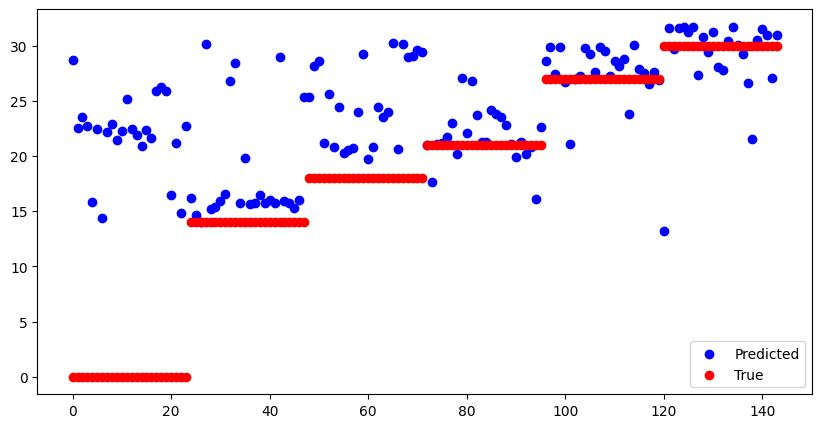

cpu
./models/model0513_2/model.pt	device: cpu
Test MSE: 15.3105
[1.3084239959716797, 1.141866683959961, 1.3732128143310547, 1.1148834228515625, 1.6063785552978516, 0.9172821044921875, 1.2723960876464844, 1.3404388427734375, 1.1175270080566406, 0.9553661346435547, 1.0913124084472656, 0.9154491424560547, 1.2873401641845703, 1.0136432647705078, 1.5358829498291016, 1.2492828369140625, 1.0585861206054688, 0.9904556274414062, 1.2059917449951172, 1.2188262939453125, 3.524073600769043, 1.1144790649414062, 2.146099090576172, 1.1402416229248047, 14.085369110107422, 14.547015190124512, 14.23115348815918, 14.160646438598633, 14.259023666381836, 14.19587230682373, 14.573657035827637, 14.629404067993164, 14.19998550415039, 14.157109260559082, 14.401885986328125, 14.349248886108398, 14.361810684204102, 14.062888145446777, 14.7797269821167, 14.284975051879883, 14.553855895996094, 14.108573913574219, 14.24354362487793, 14.16435432434082, 14.157036781311035, 14.346179008483887, 14.11671257019043, 14.638

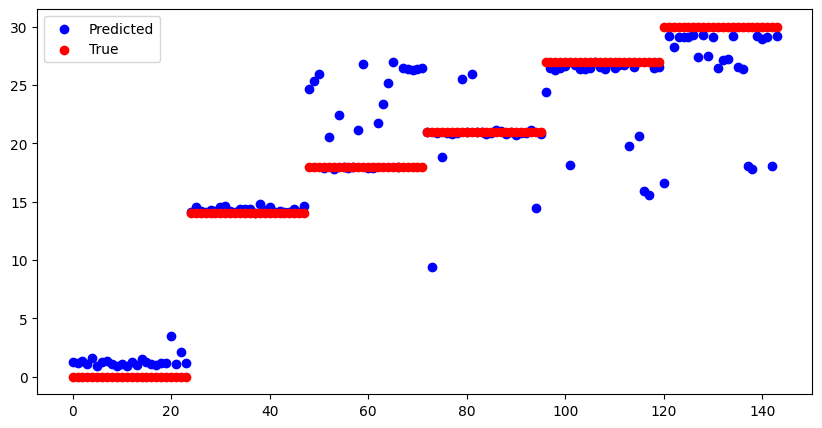

cpu
./models/model0513_3/model.pt	device: cpu
Test MSE: 18.6909
[1.084665298461914, 1.0235176086425781, 1.0610122680664062, 1.0142078399658203, 14.619288444519043, 0.9951610565185547, 15.603615760803223, 1.009500503540039, 1.0327129364013672, 1.0015945434570312, 1.056497573852539, 1.078409194946289, 1.019887924194336, 1.0404701232910156, 17.625396728515625, 1.0861434936523438, 1.0531005859375, 1.1479244232177734, 1.0634174346923828, 1.093088150024414, 24.5430850982666, 1.0804195404052734, 10.68835735321045, 1.0907726287841797, 14.038627624511719, 14.152725219726562, 14.440107345581055, 14.193777084350586, 14.11168098449707, 14.036778450012207, 14.031692504882812, 14.039505004882812, 14.129009246826172, 14.196455955505371, 14.072389602661133, 14.301910400390625, 14.081594467163086, 14.029970169067383, 14.009163856506348, 14.02194595336914, 14.039058685302734, 14.203299522399902, 14.237977981567383, 14.310613632202148, 14.093583106994629, 14.530059814453125, 14.017810821533203, 14.311826

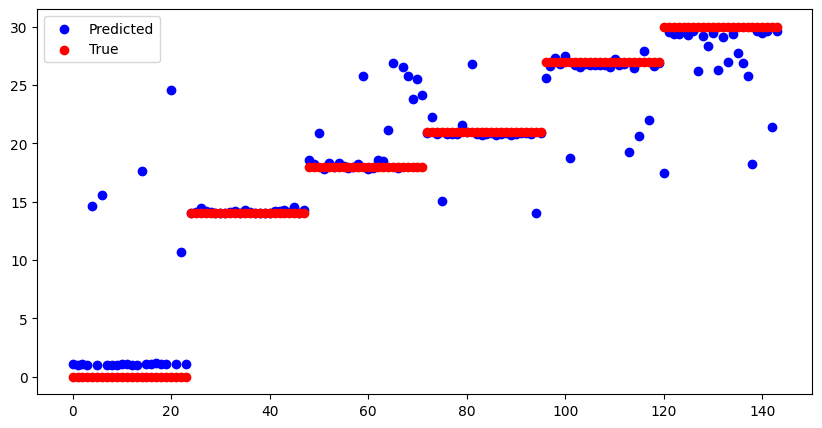

In [31]:
trained_model_paths = [
    "./models/model0513_1/model.pt",
    "./models/model0513_2/model.pt",
    "./models/model0513_3/model.pt",
]
for model_path in trained_model_paths:
    print(device)
    model = torch.load(model_path, map_location=torch.device('cpu'))
        
    print(model_path, end='\t')
    p,r = test_model(model, dataloader_test, print_prediction=False)
    print(p,r)
    xAxis = range(len(p))
    plt.figure(figsize=(10, 5))
    plt.scatter(xAxis, p, color='blue', label='Predicted')
    plt.scatter(xAxis, r,color='red', label='True')
    plt.legend()
    plt.plot()
    plt.show()

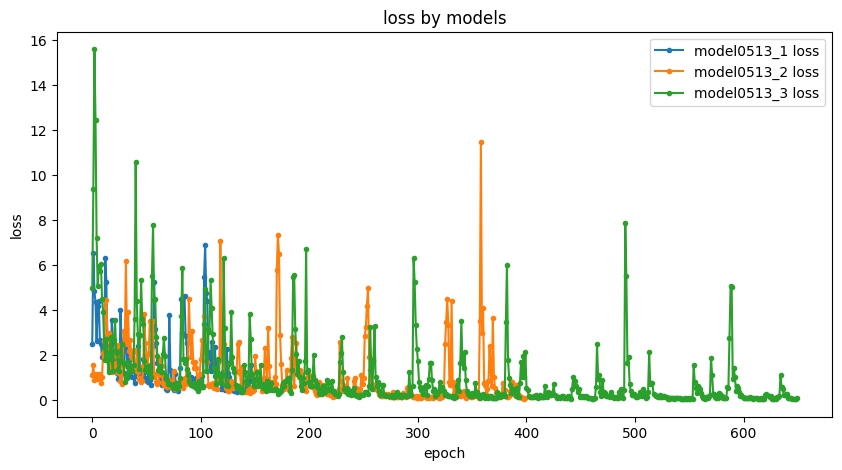

In [11]:
log_paths = ["./models/model0513_1/log.csv","./models/model0513_2/log.csv","./models/model0513_3/log.csv"]

plt.figure(figsize=(10, 5))

for log_path in log_paths:
    f = open(log_path,'r',encoding='UTF8')
    data = csv.reader(f,delimiter=',')
    next(data)

    log_data = []
    log_label = []
    for row in data:
        log_label.append(row[0])
        log_data.append(round(float(row[1]),4))
    f.close()

    
    plt.plot( log_data[100:],linestyle='-', marker='.', label = log_path.split('/')[2] + ' loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')

plt.title('loss by models')
plt.legend()    
plt.show()

    